# Step 3 — Delta Scoring & Functional Disruption (Objective 1)

**Goal:** Use AlphaGenome quantile scores to flag variants that functionally disrupt biological processes (splicing, expression, chromatin accessibility).

**Key insight from Step 2 plots:**
- `SPLICE_SITES__quantile_abs` — strongest class separation; primary disruption signal
- `RNA_SEQ__quantile_abs` — use absolute value (signed score obscures magnitude)
- `SPLICE_SITE_USAGE`, `SPLICE_JUNCTIONS` — secondary splicing signals
- `CAGE`, `ATAC` — low individual discriminative power; useful in combination

**Outputs:**
- `scores_with_flags.parquet` — scores + disruption flags + composite score
- Threshold analysis plots and ROC curves per modality
- Recommended thresholds for Objective 1 disruption calling

## Cell 1 — Imports and load data

In [3]:
import sys
!{sys.executable} -m pip install xgboost shap --break-system-packages -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize

SCORES_IN  = Path("scores_raw.parquet")
FLAGS_OUT  = Path("scores_with_flags.parquet")

df = pd.read_parquet(SCORES_IN)

# Binary label for sklearn: Pathogenic=1, Benign=0
df["label"] = (df["CLINSIG"] == "Pathogenic").astype(int)

print(f"Loaded {len(df):,} variants")
print(df["CLINSIG"].value_counts())
print(f"\nColumns: {df.columns.tolist()}")

Loaded 4,989 variants
CLINSIG
Pathogenic    2500
Benign        2489
Name: count, dtype: int64

Columns: ['variant_id', 'ATAC__quantile_score', 'ATAC__quantile_abs', 'ATAC__raw_score', 'CAGE__quantile_score', 'CAGE__quantile_abs', 'CAGE__raw_score', 'RNA_SEQ__quantile_score', 'RNA_SEQ__quantile_abs', 'RNA_SEQ__raw_score', 'SPLICE_SITES__quantile_score', 'SPLICE_SITES__quantile_abs', 'SPLICE_SITES__raw_score', 'SPLICE_SITE_USAGE__quantile_score', 'SPLICE_SITE_USAGE__quantile_abs', 'SPLICE_SITE_USAGE__raw_score', 'SPLICE_JUNCTIONS__quantile_score', 'SPLICE_JUNCTIONS__quantile_abs', 'SPLICE_JUNCTIONS__raw_score', 'CLINSIG', 'CHROM', 'POS', 'is_splice_reg', 'label']


## Cell 2 — Derive absolute quantile scores

Signed quantile scores capture direction (up/down regulation) but for disruption detection we care about **magnitude** — a large negative RNA_SEQ score is just as disruptive as a large positive one.

In [6]:
# ── Define our primary feature set ────────────────────────────────────────────
DISRUPTION_FEATURES = {
    "splice_sites"      : "SPLICE_SITES__quantile_abs",
    "splice_site_usage" : "SPLICE_SITE_USAGE__quantile_abs",
    "splice_junctions"  : "SPLICE_JUNCTIONS__quantile_abs",
    "rna_seq"           : "RNA_SEQ__quantile_abs",
    "cage"              : "CAGE__quantile_abs",
    "atac"              : "ATAC__quantile_abs",
}

# Verify all columns exist, fall back to abs(quantile_score) if needed
for name, col in DISRUPTION_FEATURES.items():
    present = col in df.columns
    if not present:
        fallback = col.replace("__quantile_abs", "__quantile_score")
        if fallback in df.columns:
            DISRUPTION_FEATURES[name] = fallback
            df[col] = df[fallback].abs()
            print(f"  {name}: using abs({fallback})")
        else:
            print(f"  WARNING: {col} not found")
    else:
        print(f"  {name}: {col} ✓")

# ── Switch composites to raw_score ────────────────────────────────────────────
# quantile_abs saturates at ~1.0 for ClinVar variants (all score in 99th percentile
# vs gnomAD common variant background) — raw scores preserve magnitude differences
RAW_FEATURES = {
    "splice_sites"      : "SPLICE_SITES__raw_score",
    "splice_site_usage" : "SPLICE_SITE_USAGE__raw_score",
    "splice_junctions"  : "SPLICE_JUNCTIONS__raw_score",
    "rna_seq"           : "RNA_SEQ__raw_score",
    "cage"              : "CAGE__raw_score",
    "atac"              : "ATAC__raw_score",
}

# Fill NaNs and take absolute value for magnitude
for name, col in RAW_FEATURES.items():
    if col in df.columns:
        df[col] = df[col].fillna(0.0).abs()
    else:
        print(f"WARNING: {col} not found")

# Composite scores using raw scores
splice_raw_cols = [RAW_FEATURES["splice_sites"],
                   RAW_FEATURES["splice_site_usage"],
                   RAW_FEATURES["splice_junctions"]]
df["splice_composite_raw"]     = df[splice_raw_cols].max(axis=1)
df["expression_composite_raw"] = df[[RAW_FEATURES["rna_seq"],
                                     RAW_FEATURES["cage"]]].max(axis=1)
df["disruption_score_raw"]     = df[list(RAW_FEATURES.values())].max(axis=1)

# Keep quantile_abs composites too — used in Cell 3 ROC analysis
splice_q_cols = [DISRUPTION_FEATURES["splice_sites"],
                 DISRUPTION_FEATURES["splice_site_usage"],
                 DISRUPTION_FEATURES["splice_junctions"]]
df["splice_composite"]     = df[splice_q_cols].max(axis=1)
df["expression_composite"] = df[[DISRUPTION_FEATURES["rna_seq"],
                                  DISRUPTION_FEATURES["cage"]]].max(axis=1)
df["disruption_score"]     = df[list(DISRUPTION_FEATURES.values())].max(axis=1)

# ── Raw score percentile check ────────────────────────────────────────────────
print("\nRaw score percentiles (Pathogenic vs Benign):")
for name, col in [("splice_composite_raw", "splice_composite_raw"),
                  ("disruption_score_raw", "disruption_score_raw"),
                  ("splice_sites_raw",     RAW_FEATURES["splice_sites"])]:
    path_scores = df[df["label"]==1][col]
    ben_scores  = df[df["label"]==0][col]
    print(f"\n  {name}:")
    for pct in [25, 50, 75, 90, 95]:
        print(f"    p{pct:02d}: Pathogenic={np.percentile(path_scores, pct):.4f}  "
              f"Benign={np.percentile(ben_scores, pct):.4f}")

  splice_sites: SPLICE_SITES__quantile_abs ✓
  splice_site_usage: SPLICE_SITE_USAGE__quantile_abs ✓
  splice_junctions: SPLICE_JUNCTIONS__quantile_abs ✓
  rna_seq: RNA_SEQ__quantile_abs ✓
  cage: CAGE__quantile_abs ✓
  atac: ATAC__quantile_abs ✓

Raw score percentiles (Pathogenic vs Benign):

  splice_composite_raw:
    p25: Pathogenic=0.2128  Benign=0.0508
    p50: Pathogenic=0.5461  Benign=0.1059
    p75: Pathogenic=1.0681  Benign=0.2954
    p90: Pathogenic=4.3969  Benign=0.6932
    p95: Pathogenic=6.7219  Benign=1.0107

  disruption_score_raw:
    p25: Pathogenic=0.2890  Benign=0.0889
    p50: Pathogenic=0.5930  Benign=0.1735
    p75: Pathogenic=1.1299  Benign=0.4077
    p90: Pathogenic=4.3969  Benign=0.7783
    p95: Pathogenic=6.7219  Benign=1.1250

  splice_sites_raw:
    p25: Pathogenic=0.0176  Benign=0.0098
    p50: Pathogenic=0.0645  Benign=0.0117
    p75: Pathogenic=0.1250  Benign=0.0312
    p90: Pathogenic=0.8159  Benign=0.0859
    p95: Pathogenic=0.9920  Benign=0.1172


## Cell 3 — Per-modality ROC and AUC analysis

NaN counts per feature column:
  SPLICE_SITES__quantile_abs: 32 NaNs (0.6%)
  SPLICE_SITE_USAGE__quantile_abs: 32 NaNs (0.6%)
  SPLICE_JUNCTIONS__quantile_abs: 51 NaNs (1.0%)
  RNA_SEQ__quantile_abs: 0 NaNs (0.0%)
  CAGE__quantile_abs: 0 NaNs (0.0%)
  ATAC__quantile_abs: 0 NaNs (0.0%)
  splice_composite: 32 NaNs (0.6%)
  expression_composite: 0 NaNs (0.0%)
  disruption_score: 0 NaNs (0.0%)

NaN counts after fill:
  SPLICE_SITES__quantile_abs: 0
  SPLICE_SITE_USAGE__quantile_abs: 0
  SPLICE_JUNCTIONS__quantile_abs: 0
  RNA_SEQ__quantile_abs: 0
  CAGE__quantile_abs: 0
  ATAC__quantile_abs: 0
  splice_composite: 0
  expression_composite: 0
  disruption_score: 0

Per-feature AUC-ROC and Average Precision (Pathogenic vs Benign):
                      auc_roc  avg_precision
disruption_score       0.7866         0.7882
splice_composite       0.7769         0.7808
splice_junctions       0.7751         0.7760
splice_site_usage      0.7736         0.7983
expression_composite   0.7626         0.7

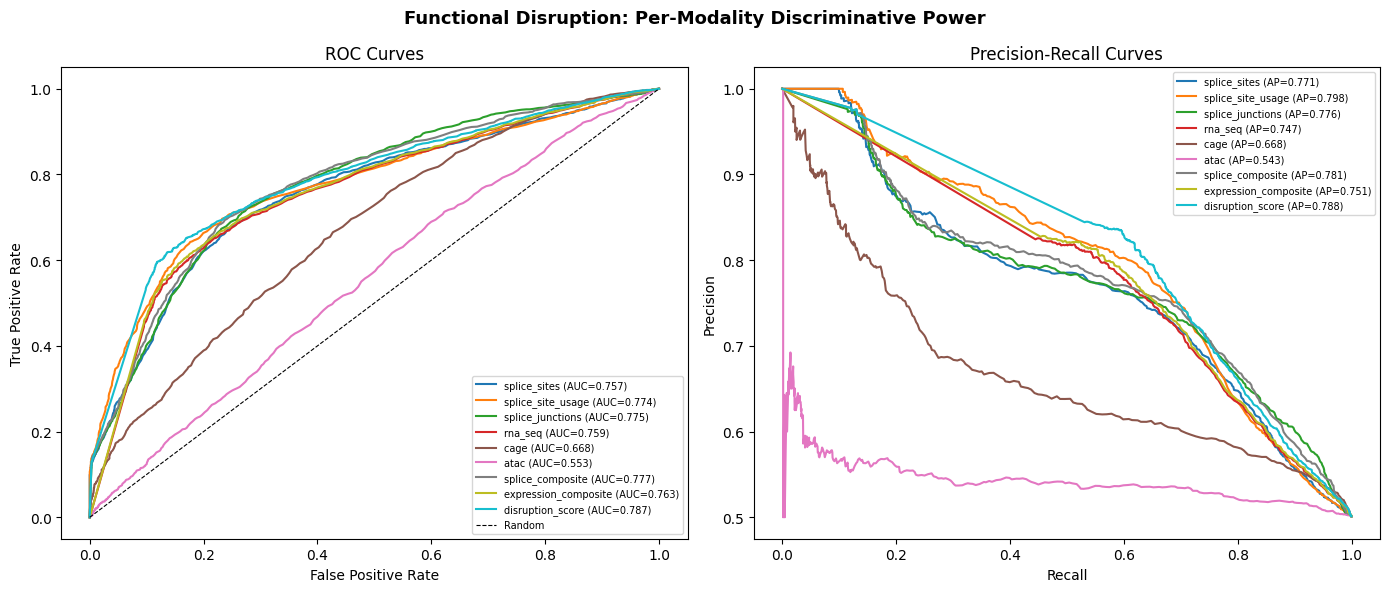

In [8]:
# ── Check and report NaN counts per feature
print("NaN counts per feature column:")
all_feat_cols_check = list(DISRUPTION_FEATURES.values()) + \
                      ["splice_composite", "expression_composite", "disruption_score"]
for col in all_feat_cols_check:
    if col in df.columns:
        n_nan = df[col].isna().sum()
        print(f"  {col}: {n_nan} NaNs ({n_nan/len(df):.1%})")

# ── Fill NaN strategy ─────────────────────────────────────────────────────────
# For splice scorers: NaN means no splice sites nearby → score = 0 (no disruption)
# For expression/chromatin: NaN means no tracks available → score = 0
# This is conservative — NaN variants are treated as non-disruptive
for col in all_feat_cols_check:
    if col in df.columns:
        df[col] = df[col].fillna(0.0)

# Recompute composites after filling NaNs
splice_cols = [
    DISRUPTION_FEATURES["splice_sites"],
    DISRUPTION_FEATURES["splice_site_usage"],
    DISRUPTION_FEATURES["splice_junctions"],
]
df["splice_composite"]      = df[splice_cols].max(axis=1)
df["expression_composite"]  = df[[DISRUPTION_FEATURES["rna_seq"],
                                   DISRUPTION_FEATURES["cage"]]].max(axis=1)
df["disruption_score"]      = df[list(DISRUPTION_FEATURES.values())].max(axis=1)

print("\nNaN counts after fill:")
for col in all_feat_cols_check:
    if col in df.columns:
        print(f"  {col}: {df[col].isna().sum()}")

# ── Now compute AUC for each feature ──────────────────────────────────────────
feature_aucs = {}
all_features = {
    **DISRUPTION_FEATURES,
    "splice_composite"     : "splice_composite",
    "expression_composite" : "expression_composite",
    "disruption_score"     : "disruption_score",
}

for name, col in all_features.items():
    if col in df.columns:
        auc_val = roc_auc_score(df["label"], df[col])
        ap_val  = average_precision_score(df["label"], df[col])
        feature_aucs[name] = {"col": col, "auc_roc": auc_val, "avg_precision": ap_val}

auc_df = pd.DataFrame(feature_aucs).T.sort_values("auc_roc", ascending=False)
auc_df[["auc_roc", "avg_precision"]] = auc_df[["auc_roc", "avg_precision"]].astype(float)

print("\nPer-feature AUC-ROC and Average Precision (Pathogenic vs Benign):")
print(auc_df[["auc_roc", "avg_precision"]].round(4).to_string())

# ── ROC and PR curves ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Functional Disruption: Per-Modality Discriminative Power",
             fontsize=13, fontweight="bold")

colours = plt.cm.tab10(np.linspace(0, 1, len(all_features)))

for (name, info), colour in zip(feature_aucs.items(), colours):
    col = info["col"]
    fpr, tpr, _ = roc_curve(df["label"], df[col])
    axes[0].plot(fpr, tpr, lw=1.5, color=colour,
                 label=f"{name} (AUC={info['auc_roc']:.3f})")

axes[0].plot([0,1],[0,1], "k--", lw=0.8, label="Random")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curves")
axes[0].legend(fontsize=7, loc="lower right")

for (name, info), colour in zip(feature_aucs.items(), colours):
    col = info["col"]
    prec, rec, _ = precision_recall_curve(df["label"], df[col])
    axes[1].plot(rec, prec, lw=1.5, color=colour,
                 label=f"{name} (AP={info['avg_precision']:.3f})")

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curves")
axes[1].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.savefig("modality_roc_curves.png", dpi=150, bbox_inches="tight")
plt.show()

## Cell 4 — Threshold analysis for Objective 1 disruption calling

Score percentiles (Pathogenic vs Benign):

  splice_composite:
    p50: Pathogenic=0.999  Benign=0.990
    p75: Pathogenic=1.000  Benign=0.997
    p90: Pathogenic=1.000  Benign=0.999
    p95: Pathogenic=1.000  Benign=1.000
    p99: Pathogenic=1.000  Benign=1.000

  disruption_score:
    p50: Pathogenic=1.000  Benign=0.999
    p75: Pathogenic=1.000  Benign=1.000
    p90: Pathogenic=1.000  Benign=1.000
    p95: Pathogenic=1.000  Benign=1.000
    p99: Pathogenic=1.000  Benign=1.000

  splice_sites:
    p50: Pathogenic=0.979  Benign=0.837
    p75: Pathogenic=0.993  Benign=0.949
    p90: Pathogenic=1.000  Benign=0.986
    p95: Pathogenic=1.000  Benign=0.992
    p99: Pathogenic=1.000  Benign=0.998


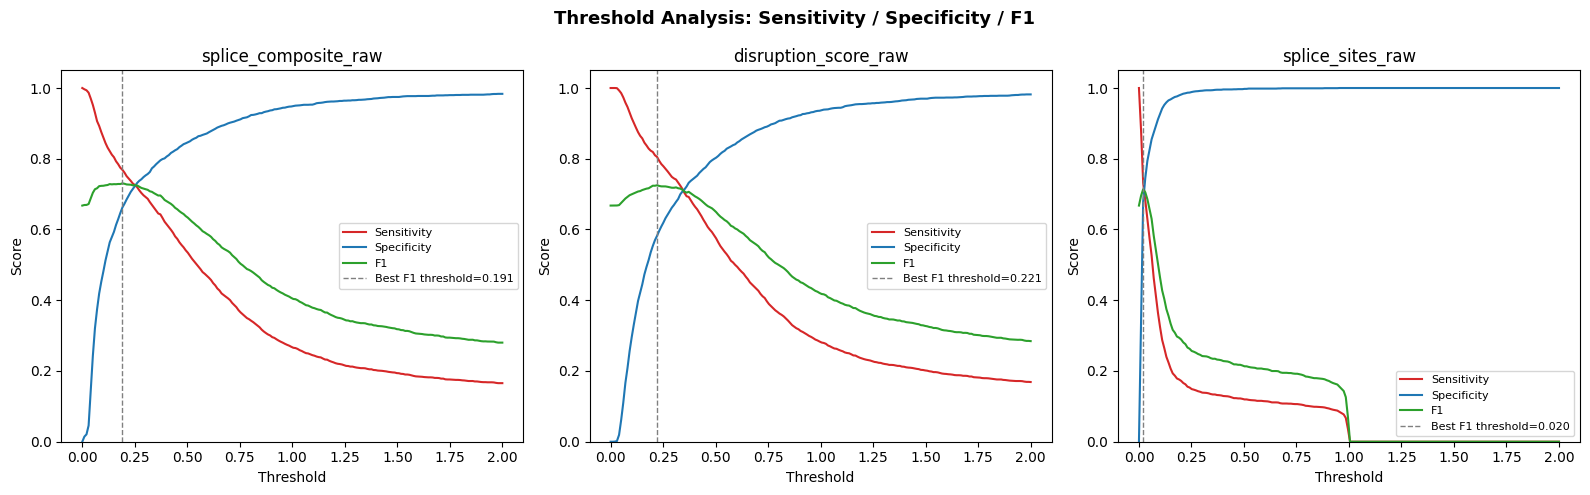


Recommended thresholds (best F1):
                      threshold      f1  sensitivity  specificity  flagged_pct
splice_composite_raw     0.1910  0.7304       0.7688       0.6621      55.3818
disruption_score_raw     0.2211  0.7250       0.8052       0.5822      61.1946
splice_sites_raw         0.0201  0.7137       0.7320       0.6794      52.6759


In [10]:
# Narrow the threshold sweep to the informative range (0.85–0.999)
# and add fixed operating point analysis at 90th/95th/99th percentiles
thresholds = np.linspace(0.85, 0.999, 200)

# Also compute score percentiles to understand the distribution
print("Score percentiles (Pathogenic vs Benign):")
for name, col in [("splice_composite", "splice_composite"),
                   ("disruption_score", "disruption_score"),
                   ("splice_sites", DISRUPTION_FEATURES["splice_sites"])]:
    path_scores = df[df["label"]==1][col]
    ben_scores  = df[df["label"]==0][col]
    print(f"\n  {name}:")
    for pct in [50, 75, 90, 95, 99]:
        print(f"    p{pct:02d}: Pathogenic={np.percentile(path_scores, pct):.3f}  "
              f"Benign={np.percentile(ben_scores, pct):.3f}")

def threshold_analysis(
    scores: pd.Series,
    labels: pd.Series,
    thresholds: np.ndarray,
) -> pd.DataFrame:
    """
    For each threshold, compute:
    - sensitivity (TPR): fraction of Pathogenic correctly flagged as disruptive
    - specificity (TNR): fraction of Benign correctly not flagged
    - precision: of those flagged, fraction that are truly Pathogenic
    - F1: harmonic mean of precision and recall
    - flagged_pct: % of all variants flagged at this threshold
    """
    rows = []
    for t in thresholds:
        flagged  = (scores >= t).astype(int)
        tp = ((flagged == 1) & (labels == 1)).sum()
        fp = ((flagged == 1) & (labels == 0)).sum()
        tn = ((flagged == 0) & (labels == 0)).sum()
        fn = ((flagged == 0) & (labels == 1)).sum()

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision   = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1 = (2 * precision * sensitivity / (precision + sensitivity)
              if (precision + sensitivity) > 0 else 0)

        rows.append({
            "threshold"   : t,
            "sensitivity" : sensitivity,
            "specificity" : specificity,
            "precision"   : precision,
            "f1"          : f1,
            "flagged_pct" : flagged.mean() * 100,
        })
    return pd.DataFrame(rows)


# Analyse thresholds for our 3 most important features
# Raw scores are unbounded — sweep from 0 upward based on percentile output
thresholds = np.linspace(0, 2.0, 200)
key_features = {
    "splice_composite_raw" : "splice_composite_raw",
    "disruption_score_raw" : "disruption_score_raw",
    "splice_sites_raw"     : RAW_FEATURES["splice_sites"],
}
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Threshold Analysis: Sensitivity / Specificity / F1",
             fontsize=13, fontweight="bold")

recommended_thresholds = {}

for ax, (name, col) in zip(axes, key_features.items()):
    t_df = threshold_analysis(df[col], df["label"], thresholds)

    ax.plot(t_df["threshold"], t_df["sensitivity"], label="Sensitivity", color="#d62728")
    ax.plot(t_df["threshold"], t_df["specificity"], label="Specificity", color="#1f77b4")
    ax.plot(t_df["threshold"], t_df["f1"],          label="F1",          color="#2ca02c")

    # Best F1 threshold
    best_idx = t_df["f1"].idxmax()
    best_t   = t_df.loc[best_idx, "threshold"]
    best_f1  = t_df.loc[best_idx, "f1"]
    ax.axvline(best_t, color="gray", linestyle="--", lw=1,
               label=f"Best F1 threshold={best_t:.3f}")

    recommended_thresholds[name] = {
        "threshold"  : best_t,
        "f1"         : best_f1,
        "sensitivity": t_df.loc[best_idx, "sensitivity"],
        "specificity": t_df.loc[best_idx, "specificity"],
        "flagged_pct": t_df.loc[best_idx, "flagged_pct"],
    }

    ax.set_title(name)
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.legend(fontsize=8)
    ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.savefig("threshold_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nRecommended thresholds (best F1):")
print(pd.DataFrame(recommended_thresholds).T.round(4).to_string())

## Cell 5 — Apply disruption flags

In [12]:
# Apply recommended thresholds to flag variants as functionally disruptive
# Use raw score thresholds from Cell 4
T_SPLICE      = recommended_thresholds["splice_composite_raw"]["threshold"]
T_DISRUPTION  = recommended_thresholds["disruption_score_raw"]["threshold"]

# Flag 1: splice disruption using raw composite
df["flag_splice_disruptive"] = (df["splice_composite_raw"] >= T_SPLICE)

# Flag 2: expression disruption using raw composite
# Use p75 of Pathogenic expression_composite_raw as threshold
T_EXPR = np.percentile(df[df["label"]==1]["expression_composite_raw"], 25)
df["flag_expr_disruptive"] = (df["expression_composite_raw"] >= T_EXPR)

# Flag 3: overall functional disruption — any modality flagged
df["flag_functionally_disruptive"] = (
    df["flag_splice_disruptive"] | df["flag_expr_disruptive"]
)

print(f"Disruption thresholds applied:")
print(f"  Splice composite (raw)  : {T_SPLICE:.4f}")
print(f"  Expression (raw p25 Path): {T_EXPR:.4f}")
print(f"  Overall disruption (raw): {T_DISRUPTION:.4f}")

print(f"\nFlag summary:")
for flag in ["flag_splice_disruptive", "flag_expr_disruptive",
             "flag_functionally_disruptive"]:
    total   = df[flag].sum()
    path_ct = df[df["label"]==1][flag].sum()
    ben_ct  = df[df["label"]==0][flag].sum()
    print(f"  {flag}:")
    print(f"    Total flagged: {total:,} ({total/len(df):.1%})")
    print(f"    Pathogenic   : {path_ct:,} ({path_ct/df['label'].sum():.1%} of Pathogenic)")
    print(f"    Benign       : {ben_ct:,} ({ben_ct/(1-df['label']).sum():.1%} of Benign)")

Disruption thresholds applied:
  Splice composite (raw)  : 0.1910
  Expression (raw p25 Path): 0.1081
  Overall disruption (raw): 0.2211

Flag summary:
  flag_splice_disruptive:
    Total flagged: 2,763 (55.4%)
    Pathogenic   : 1,922 (76.9% of Pathogenic)
    Benign       : 841 (33.8% of Benign)
  flag_expr_disruptive:
    Total flagged: 2,808 (56.3%)
    Pathogenic   : 1,875 (75.0% of Pathogenic)
    Benign       : 933 (37.5% of Benign)
  flag_functionally_disruptive:
    Total flagged: 3,395 (68.0%)
    Pathogenic   : 2,128 (85.1% of Pathogenic)
    Benign       : 1,267 (50.9% of Benign)


## Cell 6 — Disruption score heatmap by modality

NaN check after fill:
  SPLICE_SITES__raw_score: 0 NaNs, mean=0.1037, max=1.0000
  SPLICE_SITE_USAGE__raw_score: 0 NaNs, mean=0.0887, max=1.0000
  SPLICE_JUNCTIONS__raw_score: 0 NaNs, mean=0.8063, max=14.5547
  RNA_SEQ__raw_score: 0 NaNs, mean=0.1322, max=4.4268
  CAGE__raw_score: 0 NaNs, mean=0.1898, max=6.3762
  ATAC__raw_score: 0 NaNs, mean=0.1413, max=2.8009

Heatmap data:
                   Pathogenic (splice/reg)  Pathogenic (other)  \
splice_sites                        0.2752              0.1067   
splice_site_usage                   0.2468              0.0924   
splice_junctions                    1.9922              0.8955   
rna_seq                             0.1625              0.2319   
cage                                0.3660              0.1923   
atac                                0.1531              0.1547   

                   Benign (splice/reg)  Benign (other)  
splice_sites                    0.0293          0.0354  
splice_site_usage               0.0197     

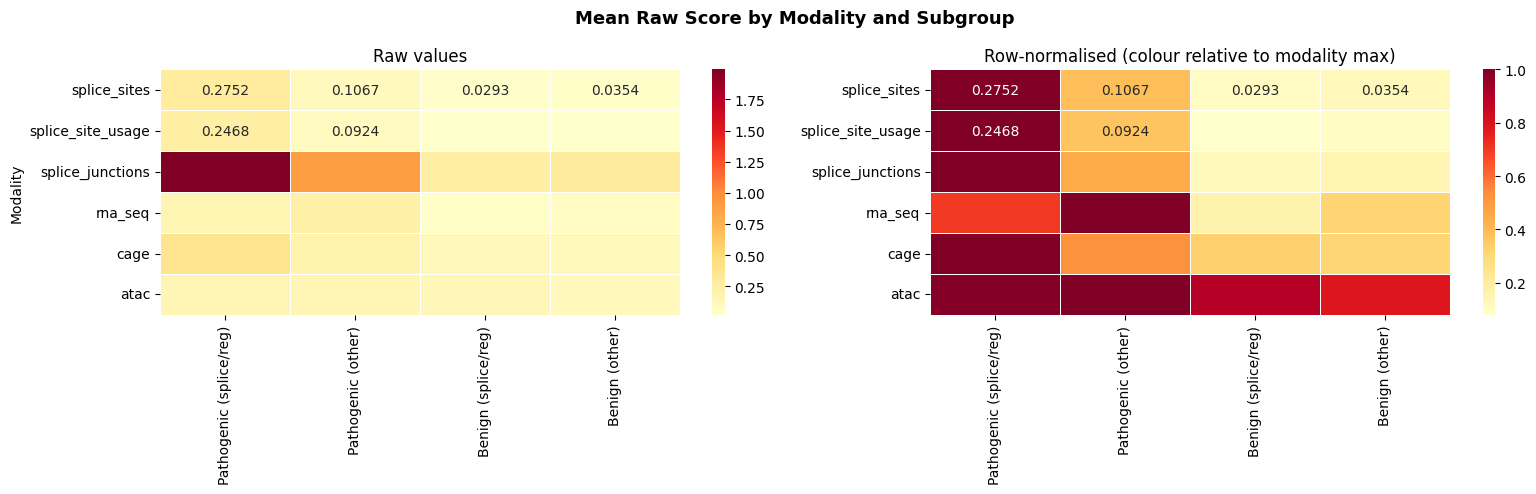

In [14]:
# Rebuild feat_cols directly from df columns to avoid any reference issues
raw_col_map = {
    "splice_sites"      : "SPLICE_SITES__raw_score",
    "splice_site_usage" : "SPLICE_SITE_USAGE__raw_score",
    "splice_junctions"  : "SPLICE_JUNCTIONS__raw_score",
    "rna_seq"           : "RNA_SEQ__raw_score",
    "cage"              : "CAGE__raw_score",
    "atac"              : "ATAC__raw_score",
}

# Recompute abs in-place explicitly
for name, col in raw_col_map.items():
    df[col] = df[col].fillna(0.0).abs()

feat_cols  = list(raw_col_map.values())
feat_names = list(raw_col_map.keys())

# Verify no NaNs remain
print("NaN check after fill:")
for col in feat_cols:
    print(f"  {col}: {df[col].isna().sum()} NaNs, "
          f"mean={df[col].mean():.4f}, max={df[col].max():.4f}")

# ── Build heatmap data as list of means then transpose ────────────────────────
# Avoids \n key mismatch issue in pd.DataFrame(dict) constructor
heatmap_data = pd.DataFrame([
    df.loc[(df["label"]==1) & df["is_splice_reg"],  feat_cols].mean(),
    df.loc[(df["label"]==1) & ~df["is_splice_reg"], feat_cols].mean(),
    df.loc[(df["label"]==0) & df["is_splice_reg"],  feat_cols].mean(),
    df.loc[(df["label"]==0) & ~df["is_splice_reg"], feat_cols].mean(),
], index=["Pathogenic (splice/reg)", "Pathogenic (other)",
          "Benign (splice/reg)",     "Benign (other)"]
).T  # transpose: modalities as rows, subgroups as columns

# Rename index from full column names to short modality names
heatmap_data.index = feat_names

print(f"\nHeatmap data:\n{heatmap_data.round(4)}")

# Explicit rename to fix ma_seq truncation bug
heatmap_data.index = [
    "splice_sites", "splice_site_usage", "splice_junctions",
    "rna_seq", "cage", "atac"
]

# Normalise each row to [0,1] for colour scale
# (splice_junctions raw scores are on a different scale to splice_sites)
# This makes colour comparable across modalities
heatmap_norm = heatmap_data.div(heatmap_data.max(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Mean Raw Score by Modality and Subgroup",
             fontsize=13, fontweight="bold")

# Left: raw values
sns.heatmap(
    heatmap_data, annot=True, fmt=".4f", cmap="YlOrRd",
    ax=axes[0], linewidths=0.5, annot_kws={"size": 10},
)
axes[0].set_title("Raw values")
axes[0].set_ylabel("Modality")

# Right: row-normalised (each modality scaled to its own max)
# makes colour differences visible even for low-magnitude modalities
sns.heatmap(
    heatmap_norm, annot=heatmap_data.round(4), fmt="", cmap="YlOrRd",
    ax=axes[1], linewidths=0.5, annot_kws={"size": 10},
)
axes[1].set_title("Row-normalised (colour relative to modality max)")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("disruption_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

**For Step 4 feature selection**:
- Keep: splice_junctions, splice_sites, splice_site_usage, rna_seq, cage
- Drop: atac

## Cell 7 — Save and summarise

In [17]:
# Save enriched dataframe with flags and composite scores
df.to_parquet(FLAGS_OUT, index=False)
print(f"Saved → {FLAGS_OUT} ({df.shape[0]:,} rows × {df.shape[1]} cols)")

print("\n" + "="*60)
print("OBJECTIVE 1 SUMMARY — Functional Disruption")
print("="*60)

print("\nPer-modality AUC-ROC using quantile_abs (ranked):")
print(auc_df[["auc_roc", "avg_precision"]].round(4).to_string())

print("\nRecommended raw score thresholds (best F1):")
for name, info in recommended_thresholds.items():
    print(f"  {name}:")
    print(f"    Threshold   : {info['threshold']:.4f}")
    print(f"    F1          : {info['f1']:.3f}")
    print(f"    Sensitivity : {info['sensitivity']:.3f}")
    print(f"    Specificity : {info['specificity']:.3f}")
    print(f"    Flagged     : {info['flagged_pct']:.1f}% of variants")

print("\nKey findings:")
top_modality = auc_df.index[0]
top_auc      = auc_df.iloc[0]["auc_roc"]
print(f"  Most discriminative modality : {top_modality} (AUC={top_auc:.4f})")
print(f"  Splice composite AUC         : {feature_aucs['splice_composite']['auc_roc']:.4f}")
print(f"  Overall disruption score AUC : {feature_aucs['disruption_score']['auc_roc']:.4f}")
n_disruptive = df["flag_functionally_disruptive"].sum()
print(f"  Variants flagged disruptive  : {n_disruptive:,} ({n_disruptive/len(df):.1%})")

# Flag enrichment summary — key Objective 1 result
print("\nDisruption flag enrichment (Pathogenic vs Benign):")
for flag in ["flag_splice_disruptive", "flag_expr_disruptive",
             "flag_functionally_disruptive"]:
    path_rate = df[df["label"]==1][flag].mean()
    ben_rate  = df[df["label"]==0][flag].mean()
    enrichment = path_rate / ben_rate if ben_rate > 0 else float("inf")
    print(f"  {flag}:")
    print(f"    Pathogenic rate : {path_rate:.1%}")
    print(f"    Benign rate     : {ben_rate:.1%}")
    print(f"    Enrichment      : {enrichment:.2f}×")

# Features to carry forward to Step 4
print("\nFeatures for Step 4 classifier:")
print("  Keep : splice_junctions, splice_sites, splice_site_usage, rna_seq, cage")
print("  Drop : atac (AUC=0.553, no subgroup separation)")

Saved → scores_with_flags.parquet (4,989 rows × 33 cols)

OBJECTIVE 1 SUMMARY — Functional Disruption

Per-modality AUC-ROC using quantile_abs (ranked):
                      auc_roc  avg_precision
disruption_score       0.7866         0.7882
splice_composite       0.7769         0.7808
splice_junctions       0.7751         0.7760
splice_site_usage      0.7736         0.7983
expression_composite   0.7626         0.7506
rna_seq                0.7591         0.7470
splice_sites           0.7572         0.7710
cage                   0.6682         0.6676
atac                   0.5535         0.5431

Recommended raw score thresholds (best F1):
  splice_composite_raw:
    Threshold   : 0.1910
    F1          : 0.730
    Sensitivity : 0.769
    Specificity : 0.662
    Flagged     : 55.4% of variants
  disruption_score_raw:
    Threshold   : 0.2211
    F1          : 0.725
    Sensitivity : 0.805
    Specificity : 0.582
    Flagged     : 61.2% of variants
  splice_sites_raw:
    Threshold   : 

## Summary

| Output | Contents | Used in |
|---|---|---|
| `scores_with_flags.parquet` | All scores + composite scores + disruption flags | Steps 4, 5 |
| `modality_roc_curves.png` | ROC and PR curves per modality | Step 5 report |
| `threshold_analysis.png` | Sensitivity/specificity/F1 vs threshold | Step 5 report |
| `disruption_heatmap.png` | Mean scores by modality and subgroup | Step 5 report |

**AUC-ROC ranking:**

- disruption_score tops at 0.787: combining all modalities wins
- Splice modalities cluster tightly: 0.757–0.777
- cage (0.668) and atac (0.554) confirmed weak — atac dropped for Step 4

**Thresholds (best F1):**

- splice_composite_raw ≥ 0.191 → F1=0.730, Sensitivity=76.9%, Specificity=66.2%
- disruption_score_raw ≥ 0.221 → F1=0.725, Sensitivity=80.5%, Specificity=58.2%

**Disruption enrichment:**

- Splice disruption: 2.28× enrichment (Pathogenic 76.9% vs Benign 33.8%). Of all Pathogenic variants, 76.9% were flagged as splice-disruptive. Only 33.8% of Benign variants were flagged. So a variant flagged as splice-disruptive is 2.28× more likely to be Pathogenic than Benign. The higher the enrichment, the more useful the flag is for distinguishing the two classes.
- Expression disruption: 2.00× enrichment. Pathogenic variants are flagged as expression-disruptive at twice the rate of Benign variants (75.0% vs 37.5%).
- Combined: 1.67× enrichment at 85.1% Pathogenic capture. When we combine both flags (flagged if either splice or expression disruptive), we catch 85.1% of all Pathogenic variants which is a very high recall. But the enrichment drops to 1.67× because we're also flagging more Benign variants (50.9%).

**Step 4:**

The 50.9% Benign false positive rate on flag_functionally_disruptive is the task Step 4 must complete. The classifier needs to learn that distinction from the score magnitudes and combinations.

**Step 4 features confirmed:**

- 5 raw scores: SPLICE_JUNCTIONS__raw_score, SPLICE_SITES__raw_score, SPLICE_SITE_USAGE__raw_score, RNA_SEQ__raw_score, CAGE__raw_score
- 3 composite scores: splice_composite_raw, expression_composite_raw, disruption_score_raw
- 3 binary flags: flag_splice_disruptive, flag_expr_disruptive, flag_functionally_disruptive
- 1 metadata: is_splice_reg